# Transient two-dimensional diffusion equation

The two-dimensional diffusion equation is

\begin{equation}
\frac{\partial U}{\partial t} = D\left(\frac{\partial^2U}{\partial x^2} + \frac{\partial^2U}{\partial y^2}\right)
\end{equation}

where $D$ is the diffusion coefficient. A simple numerical solution on the domain of the unit square $0≤x<1,0≤y<1$ approximates $U(x,y;t)$ by the discrete function $u(n)i,j$ where $x=i\Delta x$, $y=j\Delta y$ and $t=n\Delta t$. Applying finite difference approximations yields

\begin{equation}
\frac{u_{i,j}^{(n+1)} - u_{i,j}^{(n)}}{\Delta t} = D\left[ \frac{u_{i+1,j}^{(n)} - 2u_{i,j}^{(n)} + u_{i-1,j}^{(n)}}{(\Delta x)^2} + \frac{u_{i,j+1}^{(n)} - 2u_{i,j}^{(n)} + u_{i,j-1}^{(n)}}{(\Delta y)^2} \right],
\end{equation}

and hence the state of the system at time step $n+1, u_{i,j}^{(n+1)}$ may be calculated from its state at time step n, u(n)i,j through the equation

\begin{equation}
u_{i,j}^{(n+1)} = u_{i,j}^{(n)} + D\Delta t\left[ \frac{u_{i+1,j}^{(n)} - 2u_{i,j}^{(n)} + u_{i-1,j}^{(n)}}{(\Delta x)^2} + \frac{u_{i,j+1}^{(n)} - 2u_{i,j}^{(n)} + u_{i,j-1}^{(n)}}{(\Delta y)^2} \right].
\end{equation}

Consider the diffusion equation applied to a metal plate initially at temperature $T_\mathrm{cold}$ apart from a disc of a specified size which is at temperature $T_\mathrm{hot}$. We suppose that the edges of the plate are held fixed at $T_\mathrm{cold}$. The following code applies the above formula to follow the evolution of the temperature of the plate. It can be shown that the maximum time step, $\Delta t$ that we can allow without the process becoming unstable is

\begin{equation}
\Delta t = \frac{1}{2D}\frac{(\Delta x\Delta y)^2}{(\Delta x)^2 + (\Delta y)^2}.
\end{equation}


In the code below, each call to `do_timestep` updates the numpy array `u` from the results of the previous timestep, `u0`. The simplest approach to applying the partial difference equation is to use a Python loop:

```python
for i in range(1, nx-1):
    for j in range(1, ny-1):
        uxx = (u0[i+1,j] - 2*u0[i,j] + u0[i-1,j]) / dx2
        uyy = (u0[i,j+1] - 2*u0[i,j] + u0[i,j-1]) / dy2
        u[i,j] = u0[i,j] + dt * D * (uxx + uyy)
```

However, this runs extremely slowly and using vectorization will farm out these explicit loops to the much faster pre-compiled C-code underlying NumPy's array implementation.

0 1
10 2
50 3
100 4


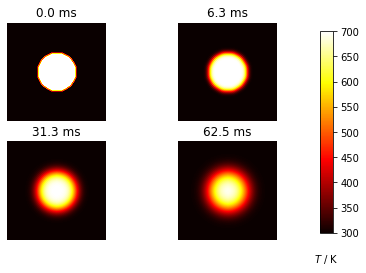

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# plate size, mm
w = h = 10.
# intervals in x-, y- directions, mm
dx = dy = 0.1
# Thermal diffusivity of steel, mm2.s-1
D = 4.

Tcool, Thot = 300, 700

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

# Initial conditions - circle of radius r centred at (cx,cy) (mm)
r, cx, cy = 2, 5, 5
r2 = r**2
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i,j] = Thot

def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 101
# Output 4 figures at these timesteps
mfig = [0, 10, 50, 100]
fignum = 0
fig = plt.figure()
for m in range(nsteps):
    u0, u = do_timestep(u0, u)
    if m in mfig:
        fignum += 1
        print(m, fignum)
        ax = fig.add_subplot(220 + fignum)
        im = ax.imshow(u.copy(), cmap=plt.get_cmap('hot'), vmin=Tcool,vmax=Thot)
        ax.set_axis_off()
        ax.set_title('{:.1f} ms'.format(m*dt*1000))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)
plt.show()


To set a common `colorbar` for the four plots we define its own `Axes`, `cbar_ax` and make room for it with `fig.subplots_adjust`. The plots all use the same colour range, defined by `vmin` and `vmax`, so it doesn't matter which one we pass in the first argument to `fig.colorbar`.

The state of the system is plotted as an image at four different stages of its evolution.